## Explore cancer gene sets

In `00_download_data/2_download_cancer_gene_data.ipynb`, we downloaded and integrated several different sets of cancer-associated genes. That script contains info about which sources we're using to get our list of cancer genes, how we're labeling them as oncogene/TSG, and how the data sources are similar/different.

In this script, we want to explore the similarities and differences between these gene sets in more detail. We have seen that the results of our classification experiments are somewhat dependent on which gene set or sets we decide to use, so understanding the similarities and differences between the gene sets will help us to put these results in context.

In [1]:
import sys
from pathlib import Path

import pandas as pd

import mpmp.config as cfg
import mpmp.utilities.data_utilities as du

%load_ext autoreload
%autoreload 2

In [2]:
# load datasets
vogelstein_df = du.load_vogelstein()
vogelstein_df.head()

,gene,Gene Name,# Mutated Tumor Samples**,Ocogene score*,Tumor Suppressor Gene score*,classification,Core pathway,Process
0,ABL1,"c-abl oncogene 1, receptor tyrosine kinase",851,0.926904,0.003046,Oncogene,Cell Cycle/Apoptosis,Cell Survival
1,ACVR1B,"activin A receptor, type IB",17,0.000000,0.423077,TSG,TGF-b,Cell Survival
2,AKT1,v-akt murine thymoma viral oncogene homolog 1,155,0.929487,0.006410,Oncogene,PI3K,Cell Survival
3,ALK,anaplastic lymphoma receptor tyrosine kinase,189,0.720000,0.010000,Oncogene,PI3K; RAS,Cell Survival
4,APC,adenomatous polyposis coli,2561,0.024553,0.917222,TSG,APC,Cell Fate


In [3]:
cosmic_df = du.load_cosmic()
cosmic_df.head()

,gene,classification
0,ABI1,TSG
1,ABL1,Oncogene
2,ABL2,Oncogene
3,ACKR3,Oncogene
4,ACVR1,Oncogene


In [4]:
# load Bailey et al. data from excel file
# this is the same as the code in 00_download_data/2_download_cancer_gene_set.ipynb
class_df = pd.read_excel(
    cfg.bailey_raw_file,
    engine='openpyxl', sheet_name='Table S1', index_col='KEY', header=3
)
class_df.drop(
    class_df.columns[class_df.columns.str.contains('Unnamed')],
    axis=1, inplace=True
)
class_df.rename(columns={'Tumor suppressor or oncogene prediction (by 20/20+)':
                         'classification'},
                inplace=True)

bailey_df = (
    class_df[((class_df.Cancer == 'PANCAN') &
             (~class_df.classification.isna()))]
).copy()

bailey_df.head()

/home/jake/anaconda3/envs/mpmp/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Gene,Cancer,classification,Decision,Tissue Frequency,Pancan Frequency,Consensus Score,Correlation adusted score,Novel,Rescue Notes,Note about previous publication
KEY,,,,,,,,,,,
ACVR1B_PANCAN,ACVR1B,PANCAN,possible tsg,official,NaN,0.010904,1.0,0.000000,0.0,NaN,Found in 24132290
ACVR2A_PANCAN,ACVR2A,PANCAN,possible tsg,official,NaN,0.013988,2.0,2.000000,0.0,NaN,Found in 24132290
AJUBA_PANCAN,AJUBA,PANCAN,tsg,official,NaN,0.009032,2.0,1.484499,0.0,NaN,Found in 24132290
AKT1_PANCAN,AKT1,PANCAN,oncogene,official,NaN,0.010133,2.5,2.500000,0.0,NaN,Found in 24132290
AMER1_PANCAN,AMER1,PANCAN,possible tsg,official,NaN,0.027426,2.0,2.000000,0.0,NaN,0


### Overlap between COSMIC/Bailey/Vogelstein

Is COSMIC a strict subset of the Bailey and Vogelstein cancer driver datasets? Or are there genes in the latter two that are not in COSMIC?

In [5]:
vogelstein_genes = set(vogelstein_df.gene.values)
cosmic_genes = set(cosmic_df.gene.values)
bailey_genes = set(bailey_df.Gene.values)

Text(0.5, 1.0, 'Overlap between cancer gene sets')

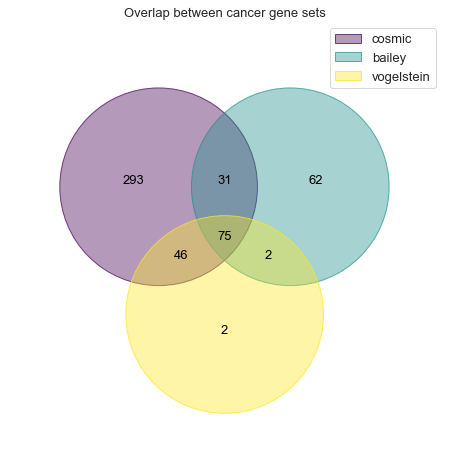

In [6]:
from venn import venn
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')

label_map = {
    'cosmic': cosmic_genes,
    'bailey': bailey_genes,
    'vogelstein': vogelstein_genes
}
venn(label_map)
plt.title('Overlap between cancer gene sets', size=13)

### Enrichment analysis of gene sets

Here, we want to do a GO molecular function enrichment analysis of the gene sets we're using. In particular, we want to compare enriched functions for the Vogelstein et al. and "merged" (Vogelstein + COSMIC + Bailey) cancer gene sets, since the classification results we see for these gene sets are so different.

The code below is based on the `goatools` example vignette, which is a Python package we use to analyze functional enrichment: https://github.com/tanghaibao/goatools/blob/main/notebooks/goea_nbt3102.ipynb

In [7]:
# download ontology data
cfg.go_data_dir.mkdir(exist_ok=True)
obo_file = cfg.go_data_dir / 'go-basic.obo'

if not obo_file.exists():
    from goatools.base import download_go_basic_obo
    obo_fname = download_go_basic_obo()
    Path(obo_fname).replace(obo_file)
else:
    print('Ontology data file already exists')

Ontology data file already exists


In [8]:
# download gene-GO associations
gene2go_file = cfg.go_data_dir / 'gene2go.gz'

if not gene2go_file.exists():
    from goatools.base import download_ncbi_associations
    gene2go_fname = download_ncbi_associations()
    Path(gene2go_fname).replace(gene2go_file)
else:
    print('Associations data file already exists')

Associations data file already exists


In [9]:
# load ontology structure
from goatools.obo_parser import GODag

obodag = GODag(str(obo_file))

/home/jake/research/mpmp/01_explore_data/go_data/go-basic.obo: fmt(1.2) rel(2022-01-13) 47,158 Terms


In [10]:
from goatools.anno.genetogo_reader import Gene2GoReader

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(str(gene2go_file), taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:03.244539 336,551 annotations, 20,706 genes, 18,724 GOs, 1 taxids READ: /home/jake/research/mpmp/01_explore_data/go_data/gene2go.gz 
MF 18,238 annotated human genes
CC 19,480 annotated human genes
BP 18,590 annotated human genes


In [11]:
# convert NCBI Gene query results for human genes to Python module
# see: https://github.com/tanghaibao/goatools/blob/main/notebooks/background_genes_ncbi.ipynb
from goatools.cli.ncbi_gene_results_to_python import ncbi_tsv_to_py

ncbi_tsv = str(cfg.go_data_dir / 'gene_result.txt')
output_py = 'genes_ncbi_9606_proteincoding.py'
ncbi_tsv_to_py(ncbi_tsv, output_py)

      19,708 lines READ:  /home/jake/research/mpmp/01_explore_data/go_data/gene_result.txt
      19,684 geneids WROTE: genes_ncbi_9606_proteincoding.py


In [12]:
# load human background gene set
from genes_ncbi_9606_proteincoding import GENEID2NT as GeneID2nt

print(len(GeneID2nt))
print(list(GeneID2nt.items())[0])

19684
(1, ntncbi(tax_id=9606, Org_name='Homo sapiens', GeneID=1, CurrentID=0, Status='live', Symbol='A1BG', Aliases=['A1B', 'ABG', 'GAB', 'HYST2477'], description='alpha-1-B glycoprotein', other_designations='alpha-1B-glycoprotein|HEL-S-163pA|epididymis secretory sperm binding protein Li 163pA', map_location='19q13.43', chromosome='19', genomic_nucleotide_accession_version='NC_000019.10', start_position_on_the_genomic_accession=58345183, end_position_on_the_genomic_accession=58353492, orientation='minus', exon_count=8, OMIM=[138670], no_hdr0=''))


In [13]:
# initialize GO enrichment analysis object
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goea = GOEnrichmentStudyNS(
    GeneID2nt.keys(), # list of human protein-coding genes
    ns2assoc, # gene/GO term associations
    obodag, # ontology structure
    propagate_counts=False,
    alpha=0.05,
    methods=['fdr_bh']
)


Load BP Ontology Enrichment Analysis ...
 86% 16,894 of 19,684 population items found in association

Load CC Ontology Enrichment Analysis ...
 92% 18,016 of 19,684 population items found in association

Load MF Ontology Enrichment Analysis ...
 89% 17,492 of 19,684 population items found in association


In [14]:
# we need to convert gene symbols to entrez IDs
from mpmp.utilities.tcga_utilities import get_symbol_map

symbol_to_entrez, old_to_new_entrez = get_symbol_map()

def gene_names_to_ids(gene_names):
    gene_ids = []
    for gene in gene_names:
        try:
            gene_id = symbol_to_entrez[gene]
            if gene_id in old_to_new_entrez.keys():
                gene_id = old_to_new_entrez[gene_id]
            gene_ids.append(gene_id)
        except KeyError:
            print('Gene {} not in ID map'.format(gene), file=sys.stderr)
            continue
    return gene_ids

In [15]:
# get entrez IDs for Vogelstein genes        
vogelstein_ids = gene_names_to_ids(vogelstein_df.gene.unique())
print(len(vogelstein_ids))
vogelstein_ids[:5]

125


[25, 91, 207, 238, 324]

In [16]:
# run GO enrichment analysis for Vogelstein genes
vogelstein_results = goea.run_study(vogelstein_ids)
vogelstein_sig_results = [r for r in vogelstein_results if r.p_fdr_bh < 0.05]


Runing BP Ontology Analysis: current study set of 125 IDs.
 99%    124 of    125 study items found in association
100%    125 of    125 study items found in population(19684)
Calculating 12,343 uncorrected p-values using fisher_scipy_stats
  12,343 terms are associated with 16,894 of 19,684 population items
   2,220 terms are associated with    124 of    125 study items
  METHOD fdr_bh:
     365 GO terms found significant (< 0.05=alpha) (365 enriched +   0 purified): statsmodels fdr_bh
     122 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 125 IDs.
100%    125 of    125 study items found in association
100%    125 of    125 study items found in population(19684)
Calculating 1,797 uncorrected p-values using fisher_scipy_stats
   1,797 terms are associated with 18,016 of 19,684 population items
     262 terms are associated with    125 of    125 study items
 

In [17]:
# save to output directory
cfg.go_output_dir.mkdir(exist_ok=True)

vogelstein_output_file = cfg.go_output_dir / 'vogelstein_enrichment.tsv'
goea.wr_tsv(str(vogelstein_output_file), vogelstein_sig_results)

    482 items WROTE: /home/jake/research/mpmp/01_explore_data/go_output/vogelstein_enrichment.tsv


In [18]:
# get non-Vogelstein gene set
all_genes = set.union(*list(label_map.values()))
non_vogelstein_genes = all_genes - label_map['vogelstein']
print(len(all_genes))
print(len(non_vogelstein_genes))

511
386


In [19]:
# get entrez IDs for non-Vogelstein genes        
non_vogelstein_ids = gene_names_to_ids(non_vogelstein_genes)
print(len(non_vogelstein_ids))
non_vogelstein_ids[:5]

383


Gene TENT5C not in ID map
Gene MRTFA not in ID map
Gene RQCD1 not in ID map


[6756, 10320, 23462, 7994, 8764]

In [20]:
# run GO enrichment analysis for non-Vogelstein genes
non_vogelstein_results = goea.run_study(non_vogelstein_ids)
non_vogelstein_sig_results = [r for r in non_vogelstein_results if r.p_fdr_bh < 0.05]


Runing BP Ontology Analysis: current study set of 383 IDs.
 99%    381 of    383 study items found in association
100%    383 of    383 study items found in population(19684)
Calculating 12,343 uncorrected p-values using fisher_scipy_stats
  12,343 terms are associated with 16,894 of 19,684 population items
   2,823 terms are associated with    381 of    383 study items
  METHOD fdr_bh:
     197 GO terms found significant (< 0.05=alpha) (196 enriched +   1 purified): statsmodels fdr_bh
     348 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 383 IDs.
100%    383 of    383 study items found in association
100%    383 of    383 study items found in population(19684)
Calculating 1,797 uncorrected p-values using fisher_scipy_stats
   1,797 terms are associated with 18,016 of 19,684 population items
     430 terms are associated with    383 of    383 study items
 

In [21]:
non_vogelstein_output_file = cfg.go_output_dir / 'non_vogelstein_enrichment.tsv'
goea.wr_tsv(str(non_vogelstein_output_file), non_vogelstein_sig_results)

    323 items WROTE: /home/jake/research/mpmp/01_explore_data/go_output/non_vogelstein_enrichment.tsv


In [22]:
# get entrez IDs for all gene set
all_ids = gene_names_to_ids(all_genes)
print(len(all_ids))
all_ids[:5]

508


Gene MRTFA not in ID map
Gene RQCD1 not in ID map
Gene TENT5C not in ID map


[10320, 139285, 672, 23462, 6125]

In [23]:
# run GO enrichment analysis for non-Vogelstein genes
all_results = goea.run_study(all_ids)
all_sig_results = [r for r in all_results if r.p_fdr_bh < 0.05]


Runing BP Ontology Analysis: current study set of 508 IDs.
 99%    505 of    508 study items found in association
100%    508 of    508 study items found in population(19684)
Calculating 12,343 uncorrected p-values using fisher_scipy_stats
  12,343 terms are associated with 16,894 of 19,684 population items
   3,793 terms are associated with    505 of    508 study items
  METHOD fdr_bh:
     658 GO terms found significant (< 0.05=alpha) (657 enriched +   1 purified): statsmodels fdr_bh
     482 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 508 IDs.
100%    508 of    508 study items found in association
100%    508 of    508 study items found in population(19684)
Calculating 1,797 uncorrected p-values using fisher_scipy_stats
   1,797 terms are associated with 18,016 of 19,684 population items
     504 terms are associated with    508 of    508 study items
 

In [24]:
all_output_file = cfg.go_output_dir / 'merged_enrichment.tsv'
goea.wr_tsv(str(all_output_file), all_sig_results)

    889 items WROTE: /home/jake/research/mpmp/01_explore_data/go_output/merged_enrichment.tsv


### Overlap of enrichment results

We want to see if there are GO terms that are enriched in one gene set (Vogelstein/non-Vogelstein) but not the other. The hope is this will tell us something about why the gene sets result in such different (relative) performance between data types.

In [25]:
go_category = 'MF'

vogelstein_enrichment_df = (
    pd.read_csv(vogelstein_output_file, sep='\t')
      .query("NS == @go_category")
      .reset_index(drop=True)
)

print(vogelstein_enrichment_df.shape)
vogelstein_enrichment_df.head()

(73, 11)


,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
0,GO:0005515,MF,e,protein binding,123/125,12436/19684,3.045367e-22,2,123,1.347270e-18,"25, 91, 207, 238, 324, 367, 472, 546, 567, 596..."
1,GO:0004713,MF,e,protein tyrosine kinase activity,15/125,93/19684,2.393061e-17,6,15,5.293451e-14,"25, 238, 1436, 1956, 2064, 2261, 2263, 2322, 3..."
2,GO:0003682,MF,e,chromatin binding,24/125,434/19684,3.853366e-16,2,24,5.682430e-13,"367, 546, 1050, 1387, 1499, 1788, 1956, 2033, ..."
3,GO:0061629,MF,e,RNA polymerase II-specific DNA-binding transcr...,17/125,173/19684,8.820619e-16,5,17,9.755604e-13,"367, 1050, 1387, 1499, 1616, 1788, 2033, 2623,..."
4,GO:0003677,MF,e,DNA binding,32/125,917/19684,1.396746e-15,4,32,1.235841e-12,"25, 472, 546, 668, 672, 1050, 1786, 1788, 2033..."


In [26]:
non_vogelstein_enrichment_df = (
    pd.read_csv(non_vogelstein_output_file, sep='\t')
      .query("NS == @go_category")
      .reset_index(drop=True)
)

print(non_vogelstein_enrichment_df.shape)
non_vogelstein_enrichment_df.head()

(90, 11)


,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
0,GO:0001228,MF,e,"DNA-binding transcription activator activity, ...",70/383,459/19684,3.183608e-42,4,70,1.408428e-38,"466, 688, 1316, 1385, 1649, 1999, 2000, 2005, ..."
1,GO:0000978,MF,e,RNA polymerase II cis-regulatory region sequen...,103/383,1178/19684,6.510212e-40,9,103,1.440059e-36,"405, 463, 466, 604, 688, 1045, 1316, 1385, 164..."
2,GO:0005515,MF,e,protein binding,351/383,12436/19684,3.630166e-38,2,351,5.353285e-35,"27, 90, 92, 208, 330, 355, 387, 399, 405, 463,..."
3,GO:0003700,MF,e,DNA-binding transcription factor activity,63/383,439/19684,2.458624e-36,2,63,2.719238e-33,"405, 463, 466, 604, 1045, 1385, 1649, 1999, 20..."
4,GO:0003677,MF,e,DNA binding,82/383,917/19684,4.682103e-32,4,82,4.142724e-29,"545, 811, 862, 1107, 1108, 1649, 1654, 2005, 2..."


Text(0.5, 1.0, 'Overlap between enriched GO MF terms')

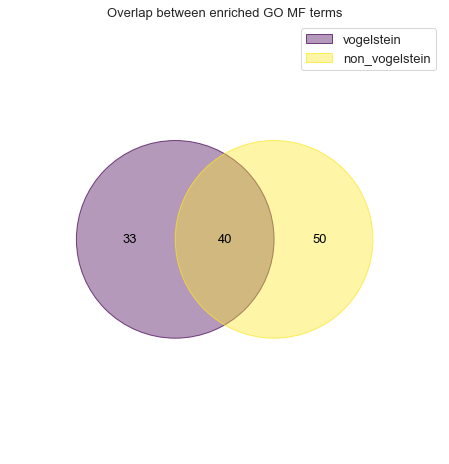

In [27]:
sns.set_style('white')

vogelstein_set = set(vogelstein_enrichment_df['# GO'].values)
non_vogelstein_set = set(non_vogelstein_enrichment_df['# GO'].values)

go_term_map = {
    'vogelstein': vogelstein_set,
    'non_vogelstein': non_vogelstein_set,
}
venn(go_term_map)
plt.title('Overlap between enriched GO {} terms'.format(go_category), size=13)

In [28]:
vogelstein_only_terms = (
    vogelstein_set - non_vogelstein_set
)
print(vogelstein_enrichment_df[vogelstein_enrichment_df['# GO'].isin(vogelstein_only_terms)].shape)
vogelstein_enrichment_df[vogelstein_enrichment_df['# GO'].isin(vogelstein_only_terms)].head(10)

(33, 11)


,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
21,GO:0032137,MF,e,guanine/thymine mispair binding,3/125,3/19684,2.500132e-07,7,3,0.000050,"2956, 4292, 4436"
24,GO:0070411,MF,e,I-SMAD binding,4/125,14/19684,1.476764e-06,4,4,0.000261,"1499, 4087, 4089, 8312"
25,GO:0043621,MF,e,protein self-association,6/125,63/19684,2.937420e-06,3,6,0.000500,"2322, 4615, 7128, 7157, 8312, 84433"
27,GO:0000400,MF,e,four-way junction DNA binding,4/125,17/19684,3.459724e-06,6,4,0.000547,"25, 2956, 4221, 4436"
28,GO:0047485,MF,e,protein N-terminus binding,7/125,102/19684,3.940392e-06,3,7,0.000601,"472, 1616, 4221, 5604, 6597, 7157, 7248"
34,GO:0005131,MF,e,growth hormone receptor binding,3/125,10/19684,2.903950e-05,5,3,0.003472,"3716, 3717, 3718"
35,GO:0030957,MF,e,Tat protein binding,3/125,10/19684,2.903950e-05,6,3,0.003472,"4869, 6597, 6598"
36,GO:0043560,MF,e,insulin receptor substrate binding,3/125,10/19684,2.903950e-05,3,3,0.003472,"3717, 5290, 5295"
37,GO:0032143,MF,e,single thymine insertion binding,2/125,2/19684,4.000618e-05,9,2,0.004425,"2956, 4436"
38,GO:0004450,MF,e,isocitrate dehydrogenase (NADP+) activity,2/125,2/19684,4.000618e-05,6,2,0.004425,"3417, 3418"


In [29]:
non_vogelstein_only_terms = (
    non_vogelstein_set - vogelstein_set
)
print(non_vogelstein_enrichment_df[non_vogelstein_enrichment_df['# GO'].isin(non_vogelstein_only_terms)].shape)
non_vogelstein_enrichment_df[non_vogelstein_enrichment_df['# GO'].isin(non_vogelstein_only_terms)].head(10)

(50, 11)


,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
5,GO:0000981,MF,e,"DNA-binding transcription factor activity, RNA...",93/383,1238/19684,1.423779e-30,3,93,1.049799e-27,"405, 463, 466, 688, 1045, 1316, 1385, 1523, 16..."
6,GO:1990837,MF,e,sequence-specific double-stranded DNA binding,57/383,556/19684,3.718490e-25,6,57,2.350086e-22,"405, 604, 688, 1045, 1316, 1385, 1523, 1999, 2..."
11,GO:0003712,MF,e,transcription coregulator activity,22/383,128/19684,5.726433e-15,2,22,2.111145e-12,"694, 2130, 2521, 2874, 3084, 3159, 4665, 5450,..."
12,GO:0043565,MF,e,sequence-specific DNA binding,28/383,248/19684,7.087254e-14,5,28,2.411847e-11,"405, 604, 865, 1523, 2034, 2308, 2309, 3091, 3..."
24,GO:0001227,MF,e,"DNA-binding transcription repressor activity, ...",25/383,320/19684,4.333128e-09,4,25,7.667904e-07,"463, 604, 1045, 2120, 2308, 2309, 3725, 4149, ..."
26,GO:0035497,MF,e,cAMP response element binding,7/383,17/19684,1.643748e-08,10,7,2.693312e-06,"1385, 3725, 6938, 8013, 8091, 64764, 90993"
27,GO:0070888,MF,e,E-box binding,10/383,49/19684,2.892473e-08,10,10,4.570107e-06,"3091, 4149, 4286, 4609, 4654, 5187, 5468, 6886..."
28,GO:0046983,MF,e,protein dimerization activity,15/383,138/19684,8.192216e-08,3,15,1.249737e-05,"4066, 4286, 4609, 4610, 4613, 6774, 6777, 6886..."
29,GO:0045296,MF,e,cadherin binding,22/383,316/19684,2.819273e-07,4,22,4.157488e-05,"90, 1009, 1500, 1654, 1656, 1969, 2060, 3646, ..."
34,GO:0019904,MF,e,protein domain specific binding,18/383,236/19684,9.335134e-07,3,18,1.179961e-04,"387, 1656, 2120, 3091, 3169, 3170, 4193, 4291,..."


In [30]:
overlap_terms = (
    non_vogelstein_set & vogelstein_set
)
print(non_vogelstein_enrichment_df[non_vogelstein_enrichment_df['# GO'].isin(overlap_terms)].shape)
non_vogelstein_enrichment_df[non_vogelstein_enrichment_df['# GO'].isin(overlap_terms)].head(10)

(40, 11)


,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
0,GO:0001228,MF,e,"DNA-binding transcription activator activity, ...",70/383,459/19684,3.183608e-42,4,70,1.408428e-38,"466, 688, 1316, 1385, 1649, 1999, 2000, 2005, ..."
1,GO:0000978,MF,e,RNA polymerase II cis-regulatory region sequen...,103/383,1178/19684,6.510212e-40,9,103,1.440059e-36,"405, 463, 466, 604, 688, 1045, 1316, 1385, 164..."
2,GO:0005515,MF,e,protein binding,351/383,12436/19684,3.630166e-38,2,351,5.353285e-35,"27, 90, 92, 208, 330, 355, 387, 399, 405, 463,..."
3,GO:0003700,MF,e,DNA-binding transcription factor activity,63/383,439/19684,2.458624e-36,2,63,2.719238e-33,"405, 463, 466, 604, 1045, 1385, 1649, 1999, 20..."
4,GO:0003677,MF,e,DNA binding,82/383,917/19684,4.682103e-32,4,82,4.142724e-29,"545, 811, 862, 1107, 1108, 1649, 1654, 2005, 2..."
7,GO:0000976,MF,e,transcription cis-regulatory region binding,35/383,214/19684,2.253071e-22,7,35,1.245948e-19,"1107, 1649, 2066, 2119, 2309, 2313, 3169, 3170..."
8,GO:0003682,MF,e,chromatin binding,46/383,434/19684,5.374864e-21,2,46,2.642044e-18,"604, 1107, 1108, 2005, 2078, 2099, 2308, 2313,..."
9,GO:0061629,MF,e,RNA polymerase II-specific DNA-binding transcr...,26/383,173/19684,5.527788e-16,5,26,2.445494e-13,"405, 1108, 1385, 1649, 2034, 2969, 3091, 3725,..."
10,GO:0019901,MF,e,protein kinase binding,41/383,467/19684,6.920778e-16,5,41,2.783411e-13,"387, 399, 595, 894, 896, 898, 1026, 1027, 1031..."
13,GO:0003713,MF,e,transcription coactivator activity,27/383,236/19684,1.453455e-13,3,27,4.592918e-11,"602, 607, 865, 2521, 2874, 3159, 3662, 4005, 4..."


Results are summarized in the Google slides here: https://docs.google.com/presentation/d/1AVK7XVRHq3xkeH7U1413jQLh79zDgS6Q4VEPsXcDTQU/edit?usp=sharing

Comparing the Vogelstein-only and non-Vogelstein-only terms, for the MF enrichment I don't honestly see a huge difference. Both gene sets are enriched for lots of "DNA binding" and "protein binding"-type terms. The non-Vogelstein gene set has some terms related to transcriptional activation/repression which the Vogelstein gene set doesn't have, so maybe these genes could induce changes to transcription which are picked up more easily in the gene expression dataset.

Looking at BP enrichment, we can see that the Vogelstein-only genes are enriched for MAPK signaling genes, and the non-Vogelstein genes are enriched for cell cycle genes and transcriptional regulators.

In [31]:
from goatools.godag_plot import plot_gos

# select some terms from the non-vogelstein genes to visualize
# if we take all of them we get an unreadable mess
terms_to_plot = [
    'GO:0000981', # DNA-binding TF activity
    'GO:0003712', # transcription coregulator activity
    'GO:0001227', # DNA-binding transcription repressor activity
    'GO:0019904', # protein domain specific binding activity
    'GO:1990837', # double-stranded DNA binding
]

plot_gos("non_vogelstein_tf.png", terms_to_plot, obodag, goea_results=non_vogelstein_results)

From the `goatools` vignette:

```
GO terms colored by P-value:
pval < 0.005 (light red)
pval < 0.01 (light orange)
pval < 0.05 (yellow)
pval > 0.05 (grey) Study terms that are not statistically significant
```

![image](non_vogelstein_tf.png)